# Code to demonstrate electon density -> energy inversion as per Semeter & Kamalabadi 2005

written by Riley Troyer Fall 2021

In [1]:
# Libraries
from datetime import datetime as dt
import gc
import h5py
from matplotlib import pyplot as plt
from matplotlib import colors
import msise00
import numpy as np
import os
import pickle
import scipy.stats
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.signal import savgol_coeffs
from scipy.integrate import trapezoid

# This might set off some warnings, but I think they can be ignored
from kaeppler_chemistry import Chemistry as chemistry

# Disable divide by zero numpy warnings
np.seterr(divide='ignore')
np.seterr(invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## The first thing I do is read in a config file with various parameters that I could change from run to run.

In [2]:
# Read in config file with dictionary of specified inputs
import config_example as config
config_data = config.run_info['config_info']

# Path to pfisr data directory
pfisr_data_dir = config_data['isr_data_dir']

# File with times for events of interest
reference_file = config_data['event_file']

# Get location of PFISR
pfrr_lat = config_data['isr_lat']
pfrr_lon = config_data['isr_lon']

# Define test flux in m^-2 s^-1
F = config_data['test_flux']

# Don't use PFISR data below this altitude in km
pfisr_min_alt = config_data['isr_min_alt']

# Get sensitivity limit of PFISR
pfisr_sensitivity = config_data['isr_sensitivity']

# Altitude in meters to approximate infinity when calculating
#...mass distance
max_msis_alt = config_data['max_msis_alt']

# Maximum number of iterations to run maximum entropy process on
max_iterations = config_data['max_iterations']

# Reduced chi square to aim for
convergence = config_data['convergence']

# Define arrays for altitude and energy bins

# Altitude in meters
#...number of points should be around the same as pfisr data
altitude_bins = config_data['altitude_bins']

# Energies in eV
#...should probably be less than altitude bins to avoid overfitting
energy_bins = config_data['energy_bins']

# Get which chemistry model to use
alpha_type = config_data['alpha_type']

# Get files to run code for
pfisr_files = config.run_info['run_files']

In [3]:
# For example code just use one file
#pfisr_filename = pfisr_files[0]
#pfisr_filename = pfisr_files[12]
# pfisr_filename = pfisr_files[25]
# pfisr_filename = pfisr_files[56]
#pfisr_filename = '20080326.001_bc_1min-fitcal.h5'
pfisr_filename = pfisr_files[44]

In [4]:
pfisr_filename

'20190301.002_bc_nenotr_1min.h5'

## Next I read in a file containing information about the $\Lambda$ function as per Semeter & Kamalabadi 2005. More on this later. As well as the file containing the ISR data.

In [5]:
def get_isr_data(pfisr_filename, pfisr_data_dir):
    """Function to get relevant data from PFISR datafile.
    INPUT
    pfisr_filename
        type: str
        about: data file name, should be .h5 file
    pfisr_data_dir
        type: str
        about: directory where isr data is stored
    OUTPUT
    utc_time
        type: array of datetimes
        about: time stamp for the start of each measurement
    pfisr_altitude
        type: array of float
        about: altitude stamp for each measurement in meters
    e_density
        type: array of float
        about: electron number density in m^-3
    de_density
        type: array of float
        about: error in number density
    """
    
    # Read in the h5 file
    pfisr_file = h5py.File(pfisr_data_dir + pfisr_filename, 'r')

    # Get the different beams and select specified angle
    beam_angle = 90
    beams = np.array(pfisr_file['BeamCodes'])

    # Get the beam with a 90 degree elevation angle
    indexes = np.linspace(0, len(beams)-1, len(beams))
    beam_num = int(indexes[np.abs(beams[:,2] - beam_angle) == 0][0])

    # Get time and convert to utc datetime
    unix_time = np.array(pfisr_file['Time']['UnixTime'])[:,0]
    utc_time = np.array([dt.utcfromtimestamp(d) 
                         for d in unix_time])

    # Get the altitude array
    pfisr_altitude = np.array(pfisr_file['NeFromPower']
                              ['Altitude'])[beam_num, :]

    # Get the uncorrected number density array
    e_density = np.array(pfisr_file['NeFromPower']
                         ['Ne_NoTr'])[:, beam_num, :]

    # Take the transpose
    e_density = np.transpose(e_density)
    
    # Find the noise floor by averaging between 55km and 60km
    #...assume this should be zero
    
    # Calculate the power given that power = density/range^2
    pfisr_range = np.array(pfisr_file['NeFromPower']
                           ['Range'])[0, :]

    # Turn 1D array into 2D array for elementwise division
    pfisr_range = np.array([pfisr_range,]*e_density.shape[1])
    pfisr_range = np.transpose(pfisr_range)
    pfisr_power = np.divide(e_density, pfisr_range**2)

    # Get the power bias
    noise_floor = np.nanmean(pfisr_power[(pfisr_altitude > 55000)
                                    & (pfisr_altitude < 60000), :],
                              axis=0)

    # Loop through each column and subtract off noise floor
    for j in range(pfisr_power.shape[1]):
        pfisr_power[:, j] = pfisr_power[:, j] - noise_floor[j]   

    # Calculate new unbiased density
    e_density = np.multiply(pfisr_power, pfisr_range**2)
        
    
    # Get error values
    try:
        de_density = np.array(pfisr_file['NeFromPower']
                              ['errNe_NoTr'])[:, beam_num, :]
        de_density = np.transpose(de_density)
    except:
        de_density = np.array(pfisr_file['NeFromPower']
                              ['dNeFrac'])[:, beam_num, :]
        de_density = np.transpose(de_density)
        de_density = de_density * e_density

    # Close file
    pfisr_file.close()
    
    return utc_time, unix_time, pfisr_altitude, e_density, de_density

In [6]:
# Read in file with energy dissipation function
lambda_filename = 'semeter_kamalabadi_lambda_function.txt'
lambda_data = np.loadtxt(lambda_filename, skiprows=5)

# Create an interpolated function from this
#...values outside set to 0
lambda_interp = interp1d(lambda_data[:, 0], lambda_data[:, 1],
                         bounds_error=False, fill_value=0)

In [7]:
# Read in the pfisr data
(utc_time, unix_time, 
 pfisr_altitude,
 e_density, de_density) = get_isr_data(pfisr_filename, pfisr_data_dir)

## Events of interest are usually only a small portion of the ISR data, so to speed up the analysis it's useful to select only these periods

In [8]:
def find_event_indices(utc_time):
    """Function to find only indices of times of interest.
    INPUT
    utc_time
        type: array of datetimes
        about: utc datetimes of all pfisr data
    OUTPUT
    slices_n
        type: list of integers
        about: indices of pfisr data that is of interest
    """
    
    # Find the date for the current pfisr file, this is a little tricky as
    #...some pfisr files span multiple days
    pfisr_dates = np.unique(np.array([d.date() for d in utc_time]))

    # Dates that are in both pa database and pfisr file
    pa_pfisr_dates = np.unique(np.array([d for d in pa_dates 
                                         if d in pfisr_dates]))

    # Loop through each of these dates and get correct indices
    indices = []
    for date in pa_pfisr_dates:
            indices.append(np.argwhere(pa_dates == date))

    # Flatten list of indices
    indices = [item[0] for sublist in indices for item in sublist]

    # Loop through each index and get data slices corresponding to the
    #...start and stop times
    slices_n = []
    for index in indices:

        # Get the date and start time of measurements
        date = pa_database[index, 0]
        start_time = date + ' ' + pa_database[index, 1]
        end_time = date + ' ' + pa_database[index, 2]

        # Convert to datetime
        start_time = dt.strptime(start_time, '%Y-%m-%d %H:%M:%S')
        end_time = dt.strptime(end_time, '%Y-%m-%d %H:%M:%S')

        # Find which indices in pfisr data correspond
        slices_n.append(np.argwhere((utc_time >= start_time) 
                                    & (utc_time <= end_time)))

    # Flatten pfisr array indices
    slices_n = [item[0] for sublist in slices_n for item in sublist]
    
    return slices_n

In [9]:
# Read in file with pulsating aurora dates, times and types
pa_database = np.loadtxt(reference_file, delimiter='\t', dtype=str)
pa_database = pa_database[1:, :]

# Convert dates to datetimes
pa_dates = np.array([dt.strptime(d, '%Y-%m-%d').date() for d 
                     in pa_database[:, 0]])

slices_n = find_event_indices(utc_time)

## For example purposes I'll only consider one time slice of the data. These calculations require information about the atmospheric density at the given time and location. To determine this I will run the MSISE00 model.

In [10]:
def get_msis_density(run_time, altitude_bins, max_alt=1001e3,
                     glat=65.117, glon=212.540):
    """Function to get MSIS calculated atmospheric densities.
    DEPENDENCIES
        msise00, numpy, scipy.interpolate.interp1d
    INPUT
    run_time
        type: datetime
        about: time to run msis code for
    altitudes
        type: array of floats
        about: altitudes in meters to run msis code for
    max_alt = 1001e3
        type: float
        about: maximum altitude in meters to run msis for. 
               Function creates a high altitude log spaced array
               between the max of altitudes and the max_alt value.
               This is primarily for approximating an indefinite integral.
    OUTPUT
    total_msis_alt
        type: array of floats
        about: altitudes values in meters including original array and
               high altitude array
    msis_interp_density
        type: scipy.interplate function
        about: 1d interpolation of msis density spanning entire altitude
               range.
    """
    
    # Run msis for lower altitudes
    msis_run_low = msise00.run(time=run_time, altkm=altitude_bins/1000,
                               glat=pfrr_lat, glon=pfrr_lon)

    # Define a higher altitude array
    msis_alt_high = np.logspace(np.log10(max(altitude_bins)+1),
                                np.log10(max_alt), 20)
    
    # Run msis for these higher altitudes
    msis_run_high = msise00.run(time=run_time, altkm=msis_alt_high/1000,
                               glat=pfrr_lat, glon=pfrr_lon)

    # Get total density data
    msis_density_low = msis_run_low['Total'].data[0, :, 0, 0]
    msis_density_high = msis_run_high['Total'].data[0, :, 0, 0]

    # Combine altitude and densities from low and high altitudes
    total_msis_alt = np.concatenate((altitude_bins, msis_alt_high))
    total_msis_density = np.concatenate((msis_density_low,
                                         msis_density_high))

    # Create a scipy interpolation function to define density v. altitude
    msis_interp_density = interp1d(total_msis_alt, total_msis_density)
    
    return total_msis_alt, msis_interp_density

In [12]:
import iri2016
# Run  MSIS for each date to see which don't work
#for pfisr_filename in pfisr_files[62:63]:
    
# Read in the pfisr data
(utc_time, unix_time, 
 pfisr_altitude,
 e_density, de_density) = get_isr_data(pfisr_filename,
                                       pfisr_data_dir)

run_time = utc_time[0]

try: 
    (total_msis_alt,
     msis_interp_density) = get_msis_density(run_time, 
                                             altitude_bins,
                                             max_alt=max_msis_alt,
                                             glat=pfrr_lat, 
                                             glon=pfrr_lon)
except:
    print('Issue with MSIS for:', run_time)

try:
    iri_run = iri2016.IRI(time=run_time,
                          altkmrange=[50000, max_msis_alt, 1000],
                          glat=pfrr_lat, glon=pfrr_lon)

except:
    print('Issue with IRI for:', run_time)

In [13]:
# Run msis for lower altitudes
msis_run_low = msise00.run(time=run_time, altkm=altitude_bins/1000,
                           glat=pfrr_lat, glon=pfrr_lon)

In [31]:
# Time slice to run inversion for
# slice_n = 684
# slice_n = 157
# slice_n = 7
slice_n = 400

#slice_n = 625
print(utc_time[slice_n])

2019-03-01 12:42:16


In [32]:
# Time associated with slice
run_time = utc_time[slice_n]

# Get MSIS calculated densities
(total_msis_alt,
 msis_interp_density) = get_msis_density(run_time, altitude_bins,
                                         max_alt=max_msis_alt,
                                         glat=pfrr_lat, glon=pfrr_lon)

# Get density for altitude bins
total_msis_density = msis_interp_density(total_msis_alt)
density_rho = msis_interp_density(altitude_bins)

## Calculate the mass distance of a particle travelling through the atmosphere. This is defined as 
## $s(z) = \frac{1}{\cos(I)}\int_{z_0}^\infty \, \rho(z)\, dz$
### where $I=0$ is the incident angle of the particles and $\rho(z)$ is the MSISE00 calculated mass density. 
### To approximate $\infty$ I integrate out to 1000 km. I do the integration using the trapezoid method, which seems to be plenty good enough.

In [33]:
def mass_distance(z_i, I=0):
    """Function to mass distance of particle traveling some distance
    into the atmosphere. Denoted s in the derivations.
    Using trapezoid rule for this, which seems to be good enough
    INPUT
    z
        type: int
        about: index of altitude that particle reached to
    I=0
        type: float
        about: angle of magnetic inclination at measuring site in radians
    OUTPUT
    s
        type: float
        about: mass distance in kg m^-2
    """
    
    # Calculate mass distance traveled 
    s = (1/np.cos(I)) * trapezoid(total_msis_density[z_i:],
                                  total_msis_alt[z_i:])
    
    return s

In [34]:
# Calculate mass distance (s) for each altitude by integrating
#...out to 1000 km (~infinity)
s = np.array([mass_distance(z) for z in range(len(altitude_bins))])

## The mass distance is needed to calculate the ion production rate. The ion production rate is important since 
## $q(z) = A(z, K) \phi(K)$
### where $z$ is altitude and $K$ is energy. So if we know $q(z)$ we can invert A and get the number flux $\phi(K)$ in the specified energy bins.

## As derived in the paper
## $q(z, K) = \frac{\Lambda(s/R) \rho(z) K F}{35.5 R(K)} $
### where $\Lambda$ is a discrete function defined in a table in the paper, $F$ is a test number flux, and $R$ is a range-energy function.

In [35]:
def barrett_hays_range_energy_func(K):
    """Function to define mass range of electron in air for a specific
    energy K in eV. From Barett & Hays 1976
    INPUT
    K
        type: float
        about: energy of electron in eV
    OUTPUT
    R
        type: float
        about: mass range of particle in kg m^-2 
    """
    # Convert energy to keV to match formula
    K = K/1000
    
    # Range function
    R = 4.3e-7 + 5.36e-6 * K**(1.67) - 0.38e-8 * K**(-0.7)
    
    # Convert R from g/cm^2 to kg/m^2
    R = R * 10
    
    return R

In [36]:
# Calculate ion production rate for each energy and store
#...in dictionary
ion_prod_rate = {}

for i, energy in enumerate(energy_bins):

    # Calculate range-energy value
    R = barrett_hays_range_energy_func(energy)

    # Get the (s/R)(z) for the energy
    s_R = s/R

    # Use s/R to get Lambda function values
    lambda_vals = lambda_interp(s_R)

    # Use all of this to calculate ion production rate as function
    #...of alt
    q = (lambda_vals * density_rho * energy * F) / (35.5 * R)

    # Write to dictionary
    ion_prod_rate[energy] = q

## Calculate the matrix $A$. Each column of this corresponds to an energy bin and is equal to the ion production rate multiplied by the energy bin width and divided by the test flux.

In [37]:
# Construct the A matrix
matrix_A = np.zeros([len(altitude_bins), len(energy_bins)])

# Loop through each energy value
for j in range(len(energy_bins)):

    # Get the size of the energy bin
    #...first bin is from zero to energy
    if j == 0:
        delta_E = energy_bins[j] - 0
    else:
        delta_E = energy_bins[j] - energy_bins[j-1]

    # Set column of matrix
    matrix_A[:, j] = ion_prod_rate[energy_bins[j]] * (delta_E/F)

## To guide the inversion process we will use the ion production rate as seen by the ISR. This is defined as
## $q(z) = \alpha n(z)^2 + \frac{dn}{dt}$
### where $n(z)$ is the ISR measured electron density. We assume $\frac{dn}{dt} = 0$. We believe this is a good assumption during pulsating aurora, where the electron density doesn't change much.
### $\alpha$ is the recombination coefficient. At some point we may include ISR temperatures to calculate this, but for the moment we just use
### $\alpha(z) = 2.5 \times 10^{-12}\, e^{-z/51.2}$ 

## Update: using chemistry code from Steve Kaeppler we can calculate a more accurate ionization rate

In [38]:
def recombination_coeff(z, alpha_type='vickrey'):
    """Function defining recombination coefficient
    INPUT
    z
        type:float
        about: altitude in kilometers
    alpha_type = 'vickrey'
        type: string
        about: what recombination coefficient to use
                other option: osepian, gledhill
    OUTPUT
    alpha
        type: float
        about: recombination coefficient in m^3/s
    """
    
    if alpha_type == 'vickrey':
        
        alpha = 2.5e-12 * np.exp(-z/51.2)
    
    if alpha_type == 'osepian':
        
        # Read in file with effective recombination coefficient values
        alpha_filename = 'effective-recombination-coefficient.txt'
        alpha_data = np.loadtxt(alpha_filename, skiprows=6)

        # Get altitude and coeff from data
        alpha_alt = alpha_data[:, 0]
        alpha_coeff = alpha_data[:, 1]*1e-6

        # Append formula value at 144 km
        alpha_alt = np.append(alpha_alt, 144)
        alpha_coeff = np.append(alpha_coeff, recombination_coeff(144))

        # Create an interpolated function from this
        #...values outside set to 0
        alpha_interp = interp1d(alpha_alt, alpha_coeff,
                                 bounds_error=False, fill_value=0)  
        
        alpha = alpha_interp(z)
    
    if alpha_type == 'gledhill':
        
        alpha = (4.3e-6 * np.exp(-2.42e-2 * z) 
                 + 8.16e12 * np.exp(-0.524 * z))
        
        # Convert to m^3
        alpha = alpha * 1e-6
    
    return alpha

def isr_ion_production_rate(slice_n, alpha_type='vickrey',
                            sic_run_num = 'E01'):
    """Function to estimate the ion production rate from isr measurements.
    There are many ways to do this that use differing chemistry
    assumptions. Vickrey 1982 is a very basic assumption for the 
    E-region and is extended to D-region. Gledhill 1986 is slightly more
    sophisticated using a best fit of many D-region measurements during
    night time aurora. Osepian 2009 is based on measurements during 
    solar proton events. The Stanford model is based on the chemistry
    model of Lehtinen 2007. 
    INPUT
    slice_n
        type: integer
        about: data slice of isr data to take
    alpha_type = 'vickrey'
        type: string
        about: what recombination coefficient to use
                other option: osepian, gledhill, stanford
    sic_run_num = 'E01'
        type: string
        about: if using SIC validation, this is which run to use
    OUTPUT
    q_estimate
        type: array of float
        about: estimated ion production rate m^-2 s^-1
    dq_estimate
        type: array of float
        about: error in ion production rate
    alphas
        type: array of float
        about: recombination coefficients
    """

    if ((alpha_type=='vickrey')
        or (alpha_type=='osepian')
        or (alpha_type=='gledhill')):
        # Read in density and errors in those measurements 
        #...for specific time
        e_density_slice = e_density[:, slice_n]
        de_density_slice = de_density[:, slice_n]

        # Make interpolation model of this data with respect to altitude
        #...but only do this for altitudes > defined minimum value,
        #...below this data can be weird
        pfisr_density_interp = interp1d(pfisr_altitude, e_density_slice)

        # Same interpolation except for error in density
        pfisr_error_interp = interp1d(pfisr_altitude, de_density_slice)

        # Calculate all recombination coeffcients
        alphas = np.array([recombination_coeff(z/1000,
                                               alpha_type=alpha_type)
                           for z in altitude_bins])

        # Multiply by pfisr density to get estimate of production rate
        #...keep sign in calculation, so don't bias high
        pfisr_signs = np.sign(pfisr_density_interp(altitude_bins))
        q_estimate = (alphas 
                      * pfisr_density_interp(altitude_bins)**2)

        # Get error dq = 2*alpha*n*dn
        dq_estimate = (2 * alphas * pfisr_density_interp(altitude_bins)
                       * pfisr_error_interp(altitude_bins))
        dq_estimate = abs(dq_estimate)
    
    elif alpha_type=='stanford':
        # Read in the chemistry class
        chem = chemistry(SteadyStateTime = 100., ISRIntegrationTime = 60.)

        # Read in density and errors in those measurements
        #...for specific time
        e_density_slice = e_density[:, slice_n]
        de_density_slice = de_density[:, slice_n]

        # Make interpolation model of this data with respect to altitude
        #...but only do this for altitudes > defined minimum value,
        #...below this data can be weird
        pfisr_density_interp = interp1d(pfisr_altitude, e_density_slice)

        # Same interpolation except for error in density
        pfisr_error_interp = interp1d(pfisr_altitude, de_density_slice)

        # Multiply by pfisr density to get estimate of production rate
        #...keep sign in calculation, so don't bias high
        pfisr_signs = np.sign(pfisr_density_interp(altitude_bins))

        # Initialize ionization in chemistry class
        #...input altitude in km and stepsize of altitude bins required
        alt_step = altitude_bins[1] - altitude_bins[0]
        chem.Set_Inital_Ionization(unix_time[slice_n],
                                   pfrr_lat, pfrr_lon,
                                   min(altitude_bins)/1000,
                                   max(altitude_bins)/1000,
                                   alt_step/1000)

        # Run chemistry code to convert density to ionization rate.
        #...make sure to run initial ionziation code first
        #...input should be in km and 1/cm^3
        #...this will output in units of cgs
        q_estimate = chem.Calculate_Ionization_From_Ne(altitude_bins/1000,
                                pfisr_density_interp(altitude_bins)/1e6,
                                chem.DregionChem)

        # Add back in negatives and convert to SI
        q_estimate = q_estimate * pfisr_signs * 1e6

        # Calculate the extracted effective recombination coefficient
        alphas = q_estimate / pfisr_density_interp(altitude_bins)**2
        
        # Match Gledhill above 90 km
        e_region_cond = altitude_bins >= 90e3
        alphas[e_region_cond] = [recombination_coeff(z/1000,
                                               alpha_type='gledhill')
                                 for z in altitude_bins[e_region_cond]]
        
        # Recalculate ion production rate
        q_estimate = alphas * pfisr_density_interp(altitude_bins)**2

        # Get error dq = 2*alpha*n*dn
        dq_estimate = (2 * alphas
                       * pfisr_density_interp(altitude_bins)
                       * pfisr_error_interp(altitude_bins))
        dq_estimate = abs(dq_estimate)
        
    elif alpha_type=='sic':
        # Read in density and errors in those measurements 
        #...for specific time
        e_density_slice = e_density[:, slice_n]
        de_density_slice = de_density[:, slice_n]

        # Make interpolation model of this data with respect to altitude
        #...but only do this for altitudes > defined minimum value,
        #...below this data can be weird
        pfisr_density_interp = interp1d(pfisr_altitude, e_density_slice)

        # Same interpolation except for error in density
        pfisr_error_interp = interp1d(pfisr_altitude, de_density_slice)

        # Calculate all recombination coeffcients
        
        # Directory where data is stored
        sic_data_dir = ('../source-energy-pa/data/pfisr-data/'
                        'sic-runs/exx_data/')

        # Read in data
        sic_alpha = np.loadtxt(sic_data_dir 
                               + sic_run_num + '_Alpha_cm3_s-1.dat')
        sic_time = np.loadtxt(sic_data_dir 
                              + sic_run_num + '_Time_yyyy_mm_dd_hh_mm_ss.dat')
        sic_alt = np.loadtxt(sic_data_dir 
                             + sic_run_num + '_alt_km.dat')

        # Convert times to datetime format
        sic_time = sorted([dt(utc_time[slice_n].year, int(d[1]), int(d[2]),
                           int(d[3]), int(d[4]), int(d[5])) for d in sic_time])
        sic_time = np.array(sic_time)

        # Get time delta between pfisr slice and sic
        sic_time_diff = np.array([abs((t - utc_time[slice_n]).total_seconds()) 
                                  for t in sic_time])

        # Get index of closest sic time
        n_sic = np.argmin(sic_time_diff)
        
        # Print warning if large time difference
        if sic_time_diff[n_sic] > 1000:
            print('Warning: SIC data not close to PFISR slice.')

        # Get slice of sic data
        sic_alpha_slice = sic_alpha[:, n_sic] * 1e-6

        # Create an interpolation of alpha to match altitude bins
        sic_alpha_interp = interp1d(sic_alt*1000, sic_alpha_slice,
                                    bounds_error=False, fill_value=0)
        alphas = sic_alpha_interp(altitude_bins)

        # Multiply by pfisr density to get estimate of production rate
        #...keep sign in calculation, so don't bias high
        pfisr_signs = np.sign(pfisr_density_interp(altitude_bins))
        q_estimate = (alphas 
                      * pfisr_density_interp(altitude_bins)**2)

        # Get error dq = 2*alpha*n*dn
        dq_estimate = (2 * alphas * pfisr_density_interp(altitude_bins)
                       * pfisr_error_interp(altitude_bins))
        dq_estimate = abs(dq_estimate)
        
    else:
        print('Enter good alpha type.')

    
    return q_estimate, dq_estimate, alphas

In [39]:
# Get estimated ion production rate and error from isr measurements
(q_estimate, 
 dq_estimate,
 alphas) = isr_ion_production_rate(slice_n, alpha_type='stanford')

## Before performing the maximum entropy iterations we need to define an initial number flux

In [40]:
def estimate_initial_number_flux(energy_bins, matrix_A):
    """Function to estimate the intial number flux for each energy bin
    INPUT
    energy_bins
        type: array of float
        about: energy values defining energy bins
    matrix_A
        type: array of float
        about: inversion matrix
    OUTPUT
    initial_num_flux
        type: array of float
        about: estimated number flux in m^-2 s^-1 for each energy bin
    """
    
    # Make an initial guess of the number flux
    initial_num_flux = np.ones(len(energy_bins))*(1e12/len(energy_bins))

    # Divide by energy bin widths
    bin_widths = energy_bins - np.roll(energy_bins, shift=1)

    # Fix first value
    bin_widths[0] = energy_bins[0] - 0

    # Set initial guess
    initial_num_flux = initial_num_flux/bin_widths

    # If full column of A matrix is zero set initial flux to zero
    for j in range(len(energy_bins)):

        if np.sum(matrix_A[:, j]) == 0:
            initial_num_flux[j] = 0
            
    return initial_num_flux

In [41]:
# Make an initial guess of the number flux
initial_num_flux = estimate_initial_number_flux(energy_bins, matrix_A)

## Perform the maximum entropy iterations to get an estimated number flux for each energy bin. I run the iterations until $\chi^2_\text{reduced} < 1.5$ between the $q(z)_\text{ISR} = \alpha(z) n(z)^2$ and $q(z)_\text{A} = A(z, K) \phi(K)$ or 1000 iterations are reached.

In [42]:
def maximum_entropy_iteration(initial_num_flux, altitude_bins,
                              energy_bins,matrix_A,
                              q_estimate, dq_estimate):
    """Function to peform the maximum entropy iterative process to
    approximate inversion of matrix A. 
    Process is outlined in Semeter & Kamalabadi 2005.
    INPUT
    initial_num_flux
        type: array of float
        about: initial guess of number flux for each energy bin 
               in m^-2 s^-1
    altitude_bins
        type: array of float
        about: altitude values in meters defining altitude bins
    energy_bins
        type: array of float
        about: energy values in eV defining energy bins
    matrix_A
        type: array of float
        about: matrix that iteration is trying to invert
    q_estimate
        type: array of float
        about: estimated ion production rate from ISR m^-2 s^-1
    dq_estimate
        type: array of float
        about: error in ion production rate of ISR
    OUTPUT
    new_num_flux
        type: array of float
        about: estimated number flux for energy bins in m^-2 s^-1
    reduced_chi_square
        type: float
        about: error in modeled fit
    good_alt_index
        type: int
        about: lower than this won't be good data
    """
    
    # Set previous value to initial at start
    old_num_flux = initial_num_flux
    new_num_flux = np.zeros(len(initial_num_flux))  
    
    # Create array to store all minimum j values
    min_js = np.zeros(len(altitude_bins), dtype=int)

    # Find all nonzero indices of A matrix
    nonzero_args = np.argwhere(matrix_A > 0)

    for i in range(len(min_js)):

        non_zeros = nonzero_args[nonzero_args[:, 0] == i]

        # If there are no non zero values in row, then set to 
        #...first instance
        if len(non_zeros) == 0:
            min_js[i] = 0

        # Otherwise find the minimum j
        else:
            min_js[i] = min(non_zeros[:, 1])

    # Initialize values
    old_chi_square = 1e3
    chi_square = 0
    old_chi2_diff = 1e9
    converged = True
    count = 0

    # Run interations until convergence or count is met
    while (old_chi2_diff > convergence):

        # Check count
        if count > max_iterations:
            print('Slice: {slice_n}. '
                  'Unable to converge. '
                  'Max iterations reached with chi2 = {chi2}'
                  .format(slice_n=slice_n,
                          chi2=round(chi_square, 2)))
            break

        # Construct the t vector
        t = 1/np.dot(matrix_A[:, min_js], old_num_flux[min_js])

        # Adjust for infinite values in regions without a nonzero j
        t[t == np.inf] = 0        

        for j in range(len(energy_bins)):

            # Construct c vector
            frac = np.inner(matrix_A, old_num_flux)/q_estimate
            c = 20 * (1 - frac) * t

            # Account for nan and infinite values
            #...this is why warning is raised
            c[np.isnan(c)] = 0
            c[c == -np.inf] = 0
            c[c == np.inf] = 0

            # Define w constant
            w = np.ones(len(altitude_bins))/len(altitude_bins)

            # Summation of matrix elements
            i_sum = np.sum(w*c*matrix_A[:, j])

            # New guess
            new_num_flux[j] = old_num_flux[j]/(1-old_num_flux[j]*i_sum)

        # Check chi squared, but only on altitudes that A is defined for
        diff=q_estimate-np.dot(matrix_A, new_num_flux)
        chi_square_array = diff**2/dq_estimate**2

        # Set undefined values to zero
        chi_square_array[np.isnan(chi_square_array)] = 0
        chi_square_array[chi_square_array == np.inf] = 0
        chi_square_array[chi_square_array == -np.inf] = 0
        
        # Get the chi squared value
        chi_square = np.sum(chi_square_array)
        
        # Do a convergence test, make sure it isn't blowing up
        if (old_chi2_diff 
            < abs(old_chi_square - chi_square)) & (count > 1000):
            print('Slice: {slice_n}. '
                  'Not converging. Stopping. '
                  'chi2 = {chi2}'
                  .format(slice_n=slice_n,
                          chi2=round(chi_square, 2)))
            converged = False
            break 

        # Set old values to new
        old_num_flux = np.copy(new_num_flux)
        old_chi2_diff = abs(old_chi_square - chi_square)
        old_chi_square = chi_square

        # Set count
        count = count + 1
        
    # Get reduced chi square, which should be around 1
    diff=q_estimate-np.dot(matrix_A, new_num_flux)
#     dof = matrix_A.shape[0] - matrix_A.shape[1]
    dof = len(q_estimate[dq_estimate < q_estimate]) - matrix_A.shape[1]
    
    # Notify of convergence
    if ((count < max_iterations) & (converged == True)):
        print('Slice: {slice_n}. '
              'Convergence reached. '
              'Iterations: {count}. '
              'reduced chi2: {chi2}'.format(slice_n=slice_n, 
                                            count=count-1,
                                            chi2=round(chi_square/dof, 2))
             )
        
    return new_num_flux, chi_square, dof, converged

In [43]:
# Perform the maximum entropy iterative process
(new_num_flux,
 chi_square,
 dof, converged) = maximum_entropy_iteration(initial_num_flux,
                                             altitude_bins, energy_bins,
                                             matrix_A,
                                             q_estimate, dq_estimate)

Slice: 400. Convergence reached. Iterations: 169. reduced chi2: 4.71


In [44]:
# Store results in dictionary
inversion_results = {}

# Write data to dictionary
d = {'altitude' : altitude_bins,
     'initial_density' : np.sqrt(np.dot(matrix_A,
                                        initial_num_flux)/alphas),
     'modeled_density' : np.sqrt(np.dot(matrix_A,
                                        new_num_flux)/alphas),
     'measured_density' : np.sqrt(q_estimate/alphas),
     'energy_bins' : energy_bins,
     'modeled_flux' : new_num_flux,
     'chi2' : chi_square,
     'dof' : dof,
     'converged' : converged,
     'units' : 'Values given in meters, seconds, electron-volts.'
    }

inversion_results[run_time] = d

# Clear temporary files in /dev/shm directory in Linux
try:
    os.system('rm /dev/shm/*')
except Exception as e: print(e)

## Plot the ISR number density and modeled number density to see how well fit worked. Also plot energy spectrum.

In [45]:
def inversion_density_plot(inversion_results, run_time):
    """Function to create and save a plot of the inversion 
    electron density.
    INPUT
    inversion_results
        type: dictionary
        about: dictionary of inversion results
    run_time
        type: datetime
        about: time to create plot for
    OUTPUT
    none
    """
    # Get altitude values
    altitude_bins = inversion_results[run_time]['altitude']

    # Get measured density
    pfisr_density_plot = inversion_results[run_time]['measured_density']
    pfisr_density_plot = pfisr_density_plot

    # Initial guess
    initial_guess_plot = inversion_results[run_time]['initial_density']
    initial_guess_plot = initial_guess_plot
    
    # Finally modeled guess
    final_guess_plot = inversion_results[run_time]['modeled_density']
    final_guess_plot = final_guess_plot
    
    # Get reduced chi2
    chi2 = inversion_results[run_time]['chi2']
    dof = inversion_results[run_time]['dof']
    reduced_chi2 = chi2/dof

    # Plot figure of initial guess, real data and fit
    fig, ax = plt.subplots()

    # Titles and axis labels
    ax.set_title(str(run_time) + r' $\chi^2_{red}=$' 
                 + str(round(reduced_chi2, 2)),
                 fontsize=14, fontweight='bold')

    ax.set_ylabel('Altitude [km]', fontsize=14)
    ax.set_xlabel(r'Electron Density [m$^{-3}$]', fontsize=14)

    # Axis
    ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=14)

    ax.set_xscale('log')
    #ax.set_xlim(1e10, 1e12)
    #ax.set_ylim(75, 140)

    # Plot PFISR data
    ax.plot(pfisr_density_plot, altitude_bins/1000,
            color='k', linewidth=2, label = 'PFISR')

    # Plot initial guess
    ax.plot(initial_guess_plot, altitude_bins/1000,
            color='C2', linewidth=2, label = 'Initial Guess')

    # Plot final guess
    ax.plot(final_guess_plot, altitude_bins/1000,
            color='C1', linewidth=2, label = 'Final Guess')
    
    ax.plot(np.sqrt(abs(dq_estimate/alphas)), altitude_bins/1000,
            color='red', label = 'PFISR Error')
    
    #ax.set_xlim(1e9, 1e12)

    plt.legend()

    plt.tight_layout()

def inversion_numflux_plot(inversion_results, run_time):
    """Function to create and save a plot of the inversion 
    energy spectrum.
    INPUT
    inversion_results
        type: dictionary
        about: dictionary of inversion results
    run_time
        type: datetime
        about: time to create plot for
    OUTPUT
    none
    """
    # Get energy values
    energy_bins = inversion_results[run_time]['energy_bins']
    
    # Get modeled number flux values
    num_flux = inversion_results[run_time]['modeled_flux']
    
    # Get differential number flux by multiplying by energy bin width
    bin_widths = energy_bins - np.roll(energy_bins, shift=1)
    
    # Fix first value
    bin_widths[0] = energy_bins[0] - 0
    
    num_flux = num_flux*bin_widths
    
    # Get reduced chi2
    chi2 = inversion_results[run_time]['chi2']
    dof = inversion_results[run_time]['dof']
    reduced_chi2 = chi2/dof

    # Plot figure of energy spectrum
    fig, ax = plt.subplots()

    # Titles and axis labels
    ax.set_title(str(run_time) + r' $\chi^2_{red}=$' 
                 + str(round(reduced_chi2, 2)),
                 fontsize=14, fontweight='bold')

    ax.set_ylabel(r'Number Flux [m$^{-2}$ s$^{-1}$ eV$^{-1}$]',
                  fontsize=14)
    ax.set_xlabel('Energy [eV]', fontsize=14)

    # Axis
    ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=14)

    ax.set_xscale('log')
    ax.set_yscale('log')

    # Plot the energy
    ax.plot(energy_bins, num_flux)

    plt.tight_layout()

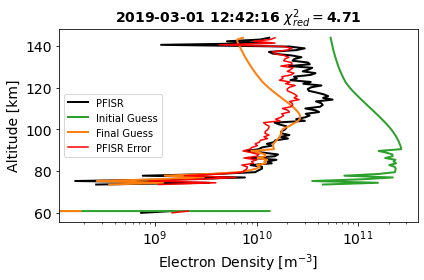

In [46]:
# Plot density
inversion_density_plot(inversion_results, run_time)
# plt.savefig('../source-energy-pa/figures/presentation-figures/'
#             + 'ne-to-q.jpg', dpi=200)

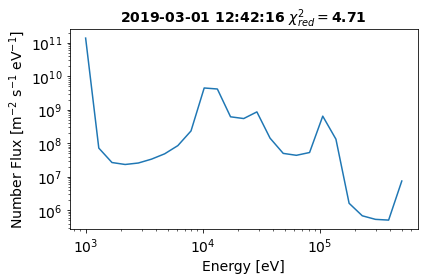

In [47]:
# Plot energy spectrum
inversion_numflux_plot(inversion_results, run_time)
# plt.savefig('../source-energy-pa/figures/presentation-figures/'
#             + 'example-spectrum.jpg', dpi=200)

In [94]:
pfisr_files[34]

'20180404.005_bc_nenotr_1min.h5'

## The following is to compare values between differing ways to estimate the ion production rate from the PFISR measurements.

In [386]:
# Is there SIC data to plot
sic_data = True

In [387]:
(q_vickrey, 
 dq_vickrey, 
 alphas_vickrey) = isr_ion_production_rate(slice_n, alpha_type='vickrey')

(q_osepian, 
 dq_osepian, 
 alphas_osepian) = isr_ion_production_rate(slice_n,
                                                 alpha_type='osepian')

(q_gledhill, 
 dq_gledhill, 
 alphas_gledhill) = isr_ion_production_rate(slice_n,
                                                  alpha_type='gledhill')
if sic_data == True:
    (q_sic, 
     dq_sic, 
     alphas_sic) = isr_ion_production_rate(slice_n, alpha_type='sic',
                                           sic_run_num='E01')

In [388]:
# Perform the maximum entropy iterative process
(new_num_flux_vickrey,
 chi_square,
 dof, converged) = maximum_entropy_iteration(initial_num_flux,
                                             altitude_bins, energy_bins,
                                             matrix_A,
                                             q_vickrey,
                                             dq_vickrey)

# Perform the maximum entropy iterative process
(new_num_flux_osepian,
 chi_square,
 dof, converged) = maximum_entropy_iteration(initial_num_flux,
                                             altitude_bins, energy_bins,
                                             matrix_A,
                                             q_osepian,
                                             dq_osepian)

# Perform the maximum entropy iterative process
(new_num_flux_gledhill,
 chi_square,
 dof, converged) = maximum_entropy_iteration(initial_num_flux,
                                             altitude_bins, energy_bins,
                                             matrix_A,
                                             q_gledhill,
                                             dq_gledhill)

if sic_data == True:
    # Perform the maximum entropy iterative process
    (new_num_flux_sic,
     chi_square,
     dof, converged) = maximum_entropy_iteration(initial_num_flux,
                                                 altitude_bins, energy_bins,
                                                 matrix_A,
                                                 q_sic,
                                                 dq_sic)

Slice: 625. Convergence reached. Iterations: 625. reduced chi2: 1.39
Slice: 625. Convergence reached. Iterations: 592. reduced chi2: 1.31
Slice: 625. Convergence reached. Iterations: 749. reduced chi2: 1.44
Slice: 625. Convergence reached. Iterations: 125. reduced chi2: 6.28


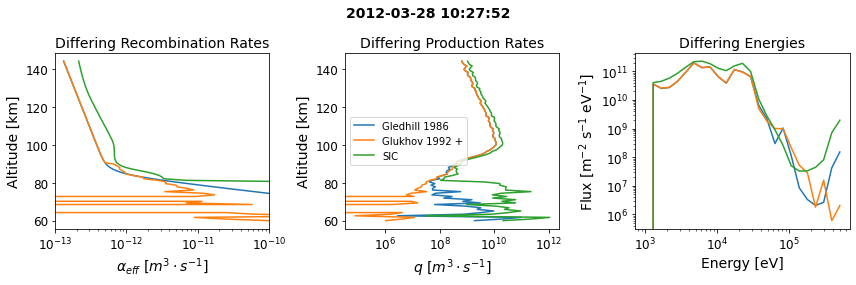

In [389]:
# Plot a comparison between the different recombination coefficients
fig = plt.figure(figsize=(12, 4))

ax0 = fig.add_subplot(1, 3, 1)
ax1 = fig.add_subplot(1, 3, 2, sharey = ax0)
ax2 = fig.add_subplot(1, 3, 3)

plt.suptitle(str(utc_time[slice_n]), fontsize=14,
              fontweight='bold')

###### Plot 1: ion recombination rates ######
# Title and axis
ax0.set_title('Differing Recombination Rates', 
             fontsize=14)
ax0.set_xlabel(r'$\alpha_{eff}$ $[m^3 \cdot s^{-1}]$', fontsize=14)
ax0.set_ylabel('Altitude [km]', fontsize=14)

# Plot the coefficients
# ax0.plot(alphas_vickrey, altitude_bins/1000, label='Vickrey 1982')
# ax0.plot(alphas_osepian, altitude_bins/1000, label='Osepian 2009')
ax0.plot(alphas_gledhill, altitude_bins/1000, label='Gledhill 1986')
ax0.plot(alphas, altitude_bins/1000, label='Glukhov 1992 +')

if sic_data == True:
    ax0.plot(alphas_sic, altitude_bins/1000, label='SIC')
    
ax0.set_xscale('log')
ax0.set_xlim(1e-13, 1e-10)
ax0.tick_params(labelsize=12)

###### Plot 2: ion production rates ######
ax1.set_title('Differing Production Rates', 
             fontsize=14)
ax1.set_xlabel(r'$q$ $[m^3 \cdot s^{-1}]$', fontsize=14)
ax1.set_ylabel('Altitude [km]', fontsize=14)

# Plot the rates
# ax1.plot(q_vickrey, altitude_bins/1000, label='Vickrey 1982')
# ax1.plot(q_osepian, altitude_bins/1000, label='Osepian 2009')
ax1.plot(q_gledhill, altitude_bins/1000, label='Gledhill 1986')
ax1.plot(q_estimate, altitude_bins/1000, label='Glukhov 1992 +')

if sic_data == True:
    ax1.plot(q_sic, altitude_bins/1000, label='SIC')

ax1.set_xscale('log')
ax1.tick_params(labelsize=12)
# yax = ax1.axes.get_yaxis()
# yax = yax.set_visible(False)

ax1.legend()


###### Plot 3: energies ######
ax2.set_title('Differing Energies', fontsize=14)
ax2.set_ylabel(r'Flux [m$^{-2}$ s$^{-1}$ eV$^{-1}$]',
              fontsize=14)
ax2.set_xlabel('Energy [eV]', fontsize=14)
ax2.tick_params(labelsize=12)
ax2.set_xscale('log')
ax2.set_yscale('log')

# Plot the energy
# ax2.plot(energy_bins, new_num_flux_vickrey*bin_widths,
#         label='Vickrey 1982')
# ax2.plot(energy_bins, new_num_flux_osepian*bin_widths,
#         label='Osepian 2009')
ax2.plot(energy_bins, new_num_flux_gledhill*bin_widths,
        label='Gledhill 1986')
ax2.plot(energy_bins, new_num_flux*bin_widths,
         label='Glukhov 1992 +')

if sic_data == True:
    ax2.plot(energy_bins, new_num_flux_sic*bin_widths,
            label='SIC')

plt.tight_layout()

# plt.savefig('../source-energy-pa/figures/semeter-inversion/'
#             'sic-chemistry-comparison/'
#             + 'chemistry-comparison-sic-4.jpg', dpi=200)